# Importación

In [31]:
!pip install yfinance

In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

In [3]:
# Importar el fichero import_data_stock_prediction.py, el cual se conecta a Yahoo Finance e importa los datos
from google.colab import drive
drive.mount('/content/drive')

execfile('/content/drive/MyDrive/StockPrediction/import_data_stock_prediction.py')

Mounted at /content/drive


In [4]:
# Importar el ficher lstm_stock_prediction.py, el cual contiene el modelo predictivo LSTM
drive.mount('/content/drive', force_remount=True)
execfile('/content/drive/MyDrive/StockPrediction/lstm_stock_prediction.py')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Se comprueba que se tiene activado la aceleración con GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Leer de Google Sheets

In [6]:
def OpenSheet(sheetName):
    gc = gspread.authorize(GoogleCredentials.get_application_default())

    worksheet = gc.open('Cartera StockPrediction').worksheet(sheetName)

    # get_all_values gives a list of rows.
    rows = worksheet.get_all_values()

    # Convert to a DataFrame and render.
    stock_wallet = pd.DataFrame.from_records(rows)
    stock_wallet.columns = stock_wallet.iloc[0]
    stock_wallet = stock_wallet.iloc[1: , :]
    return worksheet, stock_wallet

In [7]:
worksheet, stock_wallet = OpenSheet('Prediccion 27122021')
stock_wallet.iloc[0:]['Ticker'].head(5)

1       A
2     AAL
3     AAP
4    AAPL
5    ABBV
Name: Ticker, dtype: object

# Analizar una compañía

In [19]:
tickerSymbol = 'AAPL'

# Obtenemos los datos desde el día actual hasta hace 5 años
one_year_ago = datetime.now() - relativedelta(years=5)
start_date = one_year_ago.strftime('%Y-%m-%d')

#one_year_ago = datetime.now() - relativedelta(years=1)
end_date = datetime.now().strftime('%Y-%m-%d')

# Se obtiene el datafram de la empresa seleccionada y en el rango de fechas
tickerDf = GetStockDataByTicker(tickerSymbol, start_date, end_date)

In [20]:
GetStockInformationByTicker(tickerSymbol, start_date, end_date)

,Ticker,Short Name,Sector,Industry,Recommendation,Recommendation Mean,Target Low Price,Target High Price,Target Mean Price,Current Price,%,Volume,Average Volume,EBITDA,EBITDA Margins,Fecha Actualización,52 Week Change,SMA20,SMA50,SMA100,SMA200,EMA10
0,CL,Colgate-Palmolive Company,Consumer Defensive,Household & Personal Products,hold,2.8,66,98,86.6,82.655,0,1568982,4293341,4407000064,0.25412,2022-01-02 16:09,None,81.7,78.81,77.67,79.07,83.66


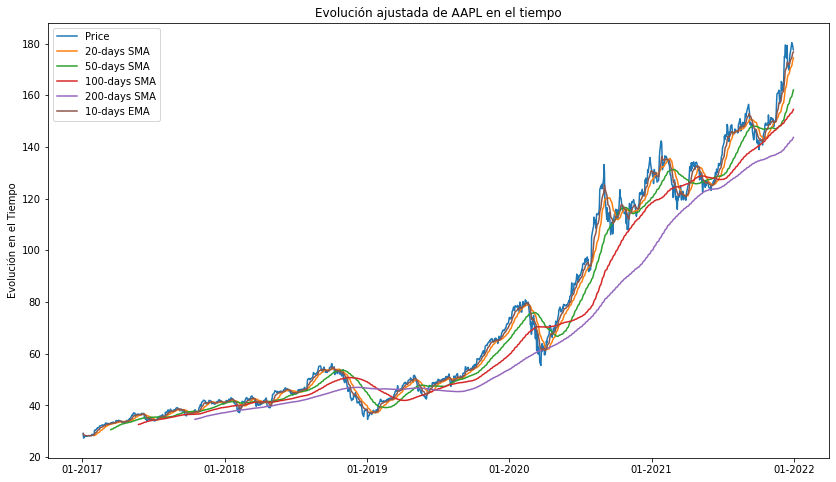

In [10]:
Graph_StockEvolutionByTime(tickerSymbol, tickerDf, 180)

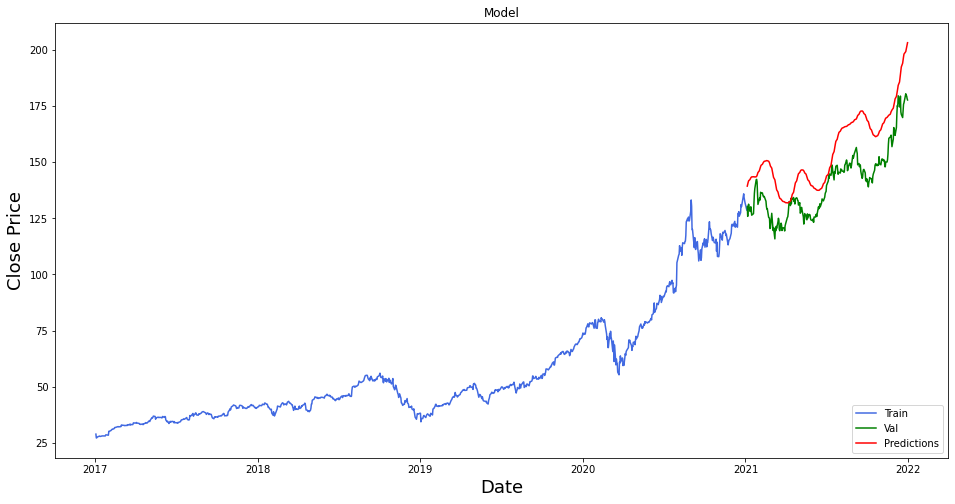

RSME =  14.703392606332482


In [13]:
x_train, y_train, dataset, training_data_len, scaler, scaled_data = TransformData(tickerDf, split_data)
LSTM_model = LSTM_Model(x_train, model_dropout, model_neuron, model_learning_rate)
LSTM_history = LSTM_fit(LSTM_model, x_train, y_train, model_epochs, model_batch_size)

predictions, y_test = LSTM_Predictions(LSTM_model, training_data_len, scaled_data, scaler, dataset)
LSTM_PlotPredictions(tickerDf.filter(['Adj Close']), training_data_len, predictions)
print("RSME = ", LSTM_RMSE(predictions, y_test))

# Predicción en Bucle

Parámetros de predicción

In [12]:
train_last_days = 60
split_data = 0.8 #80% train, 20% test

model_neuron = 50
model_epochs = 25 
model_batch_size = 32 
model_learning_rate = 1e-4
model_dropout = 0.2

In [14]:
from random import randint
from time import sleep

# last_company = Ult numeración del excel - 2 casillas
def PredictWeek_SP500(sheet_name,
                        last_company,
                        train_last_days = 60,
                        split_data = 0.8,
                        model_neuron = 50,
                        model_epochs = 25,
                        model_batch_size = 32,
                        model_learning_rate = 1e-4,
                        model_dropout = 0.2):
    # Se abre la hoja de cálculo
    worksheet, stock_wallet = OpenSheet(sheet_name)

    # Obtenemos los datos desde el día actual hasta hace 5 años
    five_year_ago = datetime.now() - relativedelta(years=5)
    start_date = five_year_ago.strftime('%Y-%m-%d')
    end_date = datetime.now().strftime('%Y-%m-%d')

    row = last_company + 2
    for tickerSymbol in stock_wallet.iloc[last_company:]['Ticker']:
        tickerSymbol = tickerSymbol.replace(".", "-")
        # Temporizador aleatorio de parada para evitar que Google Colab aborte la sesión
        #sleep(randint(10,100))

        # Se obtiene el datafram de la empresa seleccionada y en el rango de fechas
        tickerDf = GetStockDataByTicker(tickerSymbol, start_date, end_date)

        # Tratamiento de datos
        x_train, y_train, dataset, training_data_len, scaler, scaled_data = TransformData(tickerDf, split_data)

        # Entrenamiento
        LSTM_model = LSTM_Model(x_train, model_dropout, model_neuron, model_learning_rate)
        LSTM_history = LSTM_fit(LSTM_model, x_train, y_train, model_epochs, model_batch_size)

        # Testeo
        predictions, y_test = LSTM_Predictions(LSTM_model, training_data_len, scaled_data, scaler, dataset)
        rsme = LSTM_RMSE(predictions, y_test)

        # Actualizar lista de valores del Excel
        worksheet.update_cell(row, 5, str(rsme).replace('.', ','))                                   # RMSE
        
        # Predicción de la última semana
        column = 0
        for predicted_day in reversed(range(1,6)):
            day, real, predicted = LSTM_PredictNextDay(tickerDf, scaler, LSTM_model, train_last_days, predicted_day)
            if predicted_day != 0:
                worksheet.update_cell(row, 7+column, str(real).replace('.', ','))                  # Real
                worksheet.update_cell(row, 8+column, str(predicted).replace('.', ','))             # Predecido
            else:
                worksheet.update_cell(row, 8+column, str(predicted).replace('.', ','))             # Predecido  
            column += 3

        row += 1

In [18]:
sheet_name = 'Prediccion 27122021'
last_company = 476 - 2
PredictWeek_SP500(sheet_name, last_company) #train_last_days, split_data, model_neuron, model_epochs, model_batch_size, model_learning_rate, model_dropout

# Actualizar Estudio Cartera o SP_500


In [32]:
def UpdateExcelByCompany(sheetName, company, row):
    # Fechas de Inicio y Fin para obtener los datos.
    five_years_ago = datetime.now() - relativedelta(years=5)
    start_date = five_years_ago.strftime('%Y-%m-%d')
    end_date = datetime.now().strftime('%Y-%m-%d')

    # Obtenemos los datos por companía y fechas
    newCompany = GetStockInformationByTicker(company, start_date, end_date)

    # Se accede al Excel
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    worksheet = gc.open('Cartera StockPrediction').worksheet(sheetName)

    # Se actualizan los valores del Excel
    worksheet.update_cell(row, 2, str(newCompany['Short Name'][0]))                                 # Short Name
    worksheet.update_cell(row, 3, str(newCompany['Sector'][0]))                                     # Sector
    worksheet.update_cell(row, 4, str(newCompany['Industry'][0]))                                   # Industry
    worksheet.update_cell(row, 5, str(newCompany['Recommendation'][0]))                             # Recommendation
    worksheet.update_cell(row, 6, str(newCompany['Recommendation Mean'][0]).replace('.', ','))      # Recommendation Mean
    worksheet.update_cell(row, 8, str(newCompany['Target Low Price'][0]).replace('.', ','))         # Target Low Price
    worksheet.update_cell(row, 9, str(newCompany['Target High Price'][0]).replace('.', ','))        # Target High Price
    worksheet.update_cell(row, 10, str(newCompany['Target Mean Price'][0]).replace('.', ','))       # Target Mean Price
    worksheet.update_cell(row, 11, str(newCompany['52 Week Change'][0]).replace('.', ','))          # 52 Week Change
    worksheet.update_cell(row, 14, str(newCompany['EMA10'][0]).replace('.', ','))                   # EMA10
    worksheet.update_cell(row, 15, str(newCompany['SMA20'][0]).replace('.', ','))                   # SMA20
    worksheet.update_cell(row, 16, str(newCompany['SMA50'][0]).replace('.', ','))                   # SMA50
    worksheet.update_cell(row, 17, str(newCompany['SMA100'][0]).replace('.', ','))                  # SMA100
    worksheet.update_cell(row, 18, str(newCompany['SMA200'][0]).replace('.', ','))                  # SMA200
    worksheet.update_cell(row, 25, str(newCompany['EBITDA'][0]).replace('.', ','))                  # EBITDA
    worksheet.update_cell(row, 26, str(newCompany['EBITDA Margins'][0]).replace('.', ','))          # EBITDA Margins
    worksheet.update_cell(row, 27, str(newCompany['Fecha Actualización'][0]))                       # Fecha Actualización

In [ ]:
from random import randint
from time import sleep

# Nombre de la hoja donde escribir los datos
# sheetName = 'Estudio Cartera'
sheetName = 'SP_500'

worksheet, stock_wallet = OpenSheet(sheetName)
last_company = 191
row = last_company + 2
for company in stock_wallet.iloc[last_company:]['Ticker']:
    wait_time = randint(7,30)
    print(wait_time)
    sleep(wait_time)
    company = company.replace(".", "-")
    
    UpdateExcelByCompany(sheetName, company, row)
    row += 1

17
28
21
11
21
13
21
16
11
24
28
29
8
24
22
19
13
28
28
20
14
17
18
24
28
30
10
15
10
18
28
7
11
20
14
15
21
12
18
28
24
21
12
27
11
27
17
16
29
22
30
29
22
16
7
19
15
22
26
29
30
10
24
30
29
21
29
14
10
23
22
29
26
9
28
27
9
15
27
23
24
16
11
14
15
14
17
17
19
24
9
15
19
21
10
30
24
11
13
9
21
24
8
24
16
16
26
11
7
28
19
26
11
26
22
7
27
23
29
18
16
28
14
16
10
11
10
17
8
25
17
28
10
17
25
15
9
19
10
25
15
21
23
27
27
19
9
27
25
25
16
18
22
29
24
27
30
7
27
21
25
14
12
24
18
10
14
28
26
19
11
10
19
30
25
21
30
10
9
27
12
30
25
18
17
29
26
30
9
7
19
16
25
28
15
24
17
7
11
12
8
7
22
26
15
18
29
26
25
18
14
11
20
26
29
23
23
16
27
